检查一下为什么之前HSV满足论文条件之后，提取不出来patch

In [21]:
import glob,os
from openslide import open_slide, __library_version__ as openslide_lib_version, __version__ as openslide_version
import numpy as np
import random, os, glob, time
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from skimage.color import rgb2hsv

In [22]:
npy_path = '/userhome/output/p4m/dataset/adl5000/trainval_npy'
npy_list = glob.glob(os.path.join(npy_path , 'gcnn*.npy'))
print (npy_list)
for npy in npy_list:
    data = np.load(npy)
    print (data.shape)

['/userhome/output/p4m/dataset/adl5000/trainval_npy/gcnn_lev2tumor_017_y_trainval.npy', '/userhome/output/p4m/dataset/adl5000/trainval_npy/gcnn_lev2tumor_046_X1_trainval.npy', '/userhome/output/p4m/dataset/adl5000/trainval_npy/gcnn_lev2tumor_017_X1_trainval.npy', '/userhome/output/p4m/dataset/adl5000/trainval_npy/gcnn_lev2tumor_105_X1_trainval.npy', '/userhome/output/p4m/dataset/adl5000/trainval_npy/gcnn_lev2tumor_071_y_trainval.npy', '/userhome/output/p4m/dataset/adl5000/trainval_npy/gcnn_lev2tumor_071_X1_trainval.npy', '/userhome/output/p4m/dataset/adl5000/trainval_npy/gcnn_lev2tumor_046_y_trainval.npy', '/userhome/output/p4m/dataset/adl5000/trainval_npy/gcnn_lev2tumor_105_y_trainval.npy']
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


In [23]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    """ Read a region from the slide
    Return a numpy RBG array
    """
    im = slide.read_region((x, y), level, (width, height))
    im = im.convert('RGB')  # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)  # 3：rgb
    return im

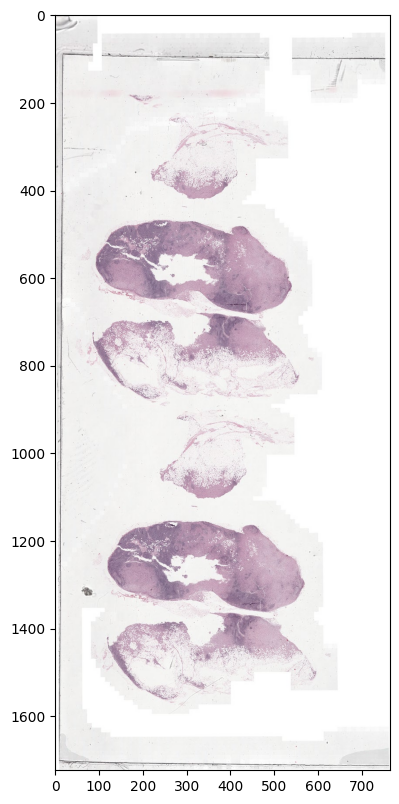

In [24]:
#查看原图
slide_path = '/userhome/dataset/CAMELYON16/training/tumor/tumor_046.tif'
slide = open_slide(slide_path)
slide_image = read_slide(slide,
                             x=0,
                             y=0,
                             level=7,
                             width=slide.level_dimensions[7][0],
                             height=slide.level_dimensions[7][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

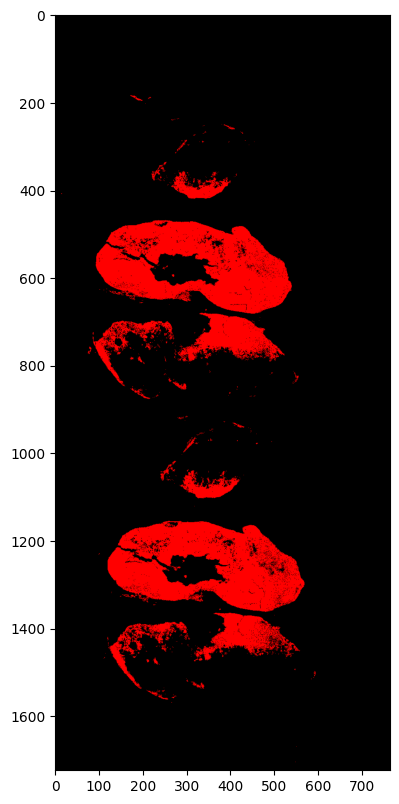

In [33]:
#查看黄显淞的tissue

img_RGB = np.array(slide_image)
img_HSV = rgb2hsv(img_RGB)
background_R = img_RGB[:, :, 0] > 203
background_G = img_RGB[:, :, 1] > 191
background_B = img_RGB[:, :, 2] > 201
tissue_RGB = np.logical_not(background_R & background_G & background_B)
tissue_S = img_HSV[:, :, 1] > 0.1113
rgb_min = 50
min_R = img_RGB[:, :, 0] > rgb_min
min_G = img_RGB[:, :, 1] > rgb_min
min_B = img_RGB[:, :, 2] > rgb_min
tissue_mask = tissue_S & tissue_RGB & min_R & min_G & min_B
indices = np.where(tissue_mask == 1)
filtered_tissue_pixels = zip(indices[0], indices[1])
filtered_tissue_regions = apply_mask(slide_image, filtered_tissue_pixels)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(filtered_tissue_regions)

max satuation of hsv: 1.0
min saturation of hsv: 0.0


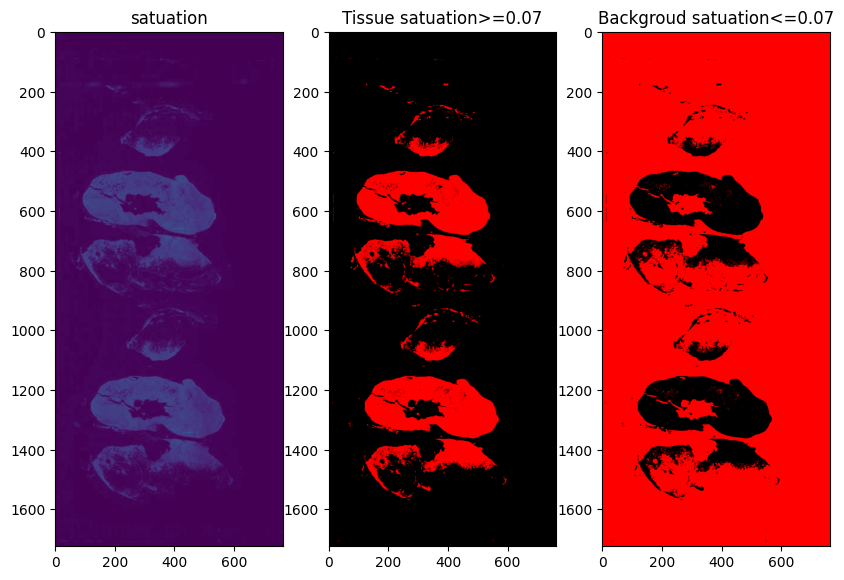

In [34]:
#检查satuation

def apply_mask(im, mask, color=(1, 0, 0)):
    """ Return the mask as an image
    """
    masked = np.zeros(im.shape)
    for x, y in mask: masked[x][y] = color
    return masked

fig, axes = plt.subplots(1, 3, figsize=(10, 30), dpi=100)

print ('max satuation of hsv:',np.max(img_HSV))
print ('min saturation of hsv:',np.min(img_HSV))
# 绘制Satuation图
a = axes[0]
tissue_S = img_HSV[:, :, 1]
indices = np.where(tissue_S  == 1)
tissue_pixels = zip(indices[0], indices[1])
tissue_regions = apply_mask(slide_image, tissue_pixels)
a.set_title('satuation')
a.imshow(tissue_S)


threshold = 0.07 
# 绘制符合Satuation>0.07的区域
b = axes[1]
filtered_tissue_S = img_HSV[:, :, 1] >= threshold
filtered_indices = np.where(filtered_tissue_S == 1)
filtered_tissue_pixels = zip(filtered_indices[0], filtered_indices[1])
filtered_tissue_regions = apply_mask(slide_image, filtered_tissue_pixels)
b.set_title('Tissue satuation>='+ str(threshold))
b.imshow(filtered_tissue_regions)


# 绘制余下的区域
c = axes[2]
rest_tissue_S = img_HSV[:, :, 1] < threshold
rest_indices = np.where(rest_tissue_S == 1)
rest_tissue_pixels = zip(rest_indices[0], rest_indices[1])
rest_tissue_regions = apply_mask(slide_image, rest_tissue_pixels)
c.set_title('Backgroud satuation<='+str(threshold))
c.imshow(rest_tissue_regions)

max value of hsv: 1.0
min value of hsv: 0.0
min value above 0: 0.0039215686274509665
mean value of hsv: 0.4168018010073642
mean medianvalue of hsv: 0.16666666666666666


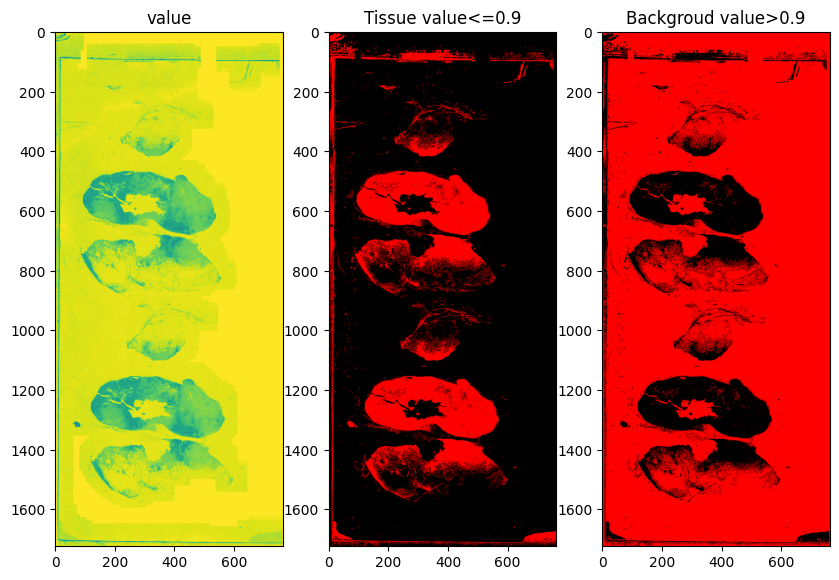

In [30]:
#检查value

def apply_mask(im, mask, color=(1, 0, 0)):
    """ Return the mask as an image
    """
    masked = np.zeros(im.shape)
    for x, y in mask: masked[x][y] = color
    return masked

fig, axes = plt.subplots(1, 3, figsize=(10, 30), dpi=100)

print ('max value of hsv:',np.max(img_HSV))
print ('min value of hsv:',np.min(img_HSV))
print ('min value above 0:',np.min(img_HSV.ravel()[np.flatnonzero(img_HSV)]))
print ('mean value of hsv:',np.mean(img_HSV))
print ('mean medianvalue of hsv:',np.median(img_HSV))

# 绘制Satuation图
a = axes[0]
tissue_V = img_HSV[:, :, 2]
indices = np.where(tissue_V  == 1)
tissue_pixels = zip(indices[0], indices[1])
tissue_regions = apply_mask(slide_image, tissue_pixels)
a.set_title('value')
a.imshow(tissue_V)

threhold = 0.9
# 绘制符合Satuation>0.07的区域
b = axes[1]
filtered_tissue_V = img_HSV[:, :, 2] <= threhold
filtered_indices = np.where(filtered_tissue_V == 1)
filtered_tissue_pixels = zip(filtered_indices[0], filtered_indices[1])
filtered_tissue_regions = apply_mask(slide_image, filtered_tissue_pixels)
b.set_title('Tissue value<=' + str(threhold))
b.imshow(filtered_tissue_regions)


# 绘制余下的区域
c = axes[2]
rest_tissue_V = img_HSV[:, :, 2] > threhold
rest_indices = np.where(rest_tissue_V == 1)
rest_tissue_pixels = zip(rest_indices[0], rest_indices[1])
rest_tissue_regions = apply_mask(slide_image, rest_tissue_pixels)
c.set_title('Backgroud value>' + str(threhold))
c.imshow(rest_tissue_regions)

In [36]:
# 合并起来

# 非（A&B）
threshold_S = 0.07
threshold_V = 0.1
non_tissue_S = img_HSV[:, :, 1]<threshold_S
non_tissue_V = img_HSV[:, :, 2]>threshold_V
non_tissue_mask = non_tissue_S & non_tissue_V
img_HSV[non_tissue_mask] = 0

plt.figure(figsize=(10,10), dpi=100)
plt.title('Rejected if S<'+str(threshold_S)+'and V>'+str(threshold_V))
plt.imshow(img_HSV)



ValueError: either both or neither of x and y should be given

In [ ]:

# 非A or 非B
threshold_S = 0.07
threshold_V = 0.1  #0.9
tissue_S = img_HSV[:, :, 1]>=threshold_S
tissue_V = img_HSV[:, :, 2]<=threshold_V
tissue_mask = tissue_S | tissue_V
indices = np.where(tissue_mask == 1)
tissue_pixels = zip(indices[0], indices[1])
tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.figure(figsize=(10,10), dpi=100)
plt.title('Accept if S>='+str(threshold_S)+'or V<='+str(threshold_V))
plt.imshow(tissue_regions)